In [20]:
import pandas as pd
import numpy as np
import imblearn
import matplotlib.pyplot as plt
import optuna   

# sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder

# models
from xgboost import XGBClassifier

# msc
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [21]:
# load the data
train = pd.read_csv('../data/train_folds.csv')
test = pd.read_csv('../data/test_eda.csv')
sample_submission = pd.read_csv('../data/SampleSubmission.csv')
train.head(2)

,Unnamed: 0,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID,PURCHASEDAT_MONTH,PURCHASEDAT_DAY,PURCHASEDAT_HOUR,PURCHASEDAT_MINUTE,PURCHASEDAT_DAYOFWEEK,PAID_AT,kfold
0,0,2022-05-04 10:25:50.588042+00:00,UONSDA CHURCH MOGERE MWAYO TITHE,Rent / Mortgage,1700,2022-05-04 13:56:00+00:00,False,25,Male,3,10000,ID_ZX4DCF4K,ID_04mk78fa,5,4,13,56,2,afternoon,1
1,1,2021-10-25 16:18:38.586837+00:00,PARK N GO,Transport & Fuel,100,2021-10-24 14:12:00+00:00,False,25,Female,4,90000,ID_U9WZMGJZ,ID_04xkfb07,10,24,14,12,6,afternoon,9


In [22]:
# we don't require the training folds
train.drop(['kfold', 'Unnamed: 0'], axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
train.shape

(373, 18)

In [6]:
# separating the features with the labels
y = train['MERCHANT_CATEGORIZED_AS']
X = train.drop('MERCHANT_CATEGORIZED_AS', axis=1)
print(X.shape, y.shape)

(373, 17) (373,)


Class=10, n=2 (0.536%)
Class=12, n=29 (7.775%)
Class=1, n=43 (11.528%)
Class=8, n=5 (1.340%)
Class=0, n=78 (20.912%)
Class=9, n=43 (11.528%)
Class=6, n=50 (13.405%)
Class=11, n=21 (5.630%)
Class=4, n=41 (10.992%)
Class=5, n=41 (10.992%)
Class=3, n=12 (3.217%)
Class=7, n=6 (1.609%)
Class=2, n=2 (0.536%)


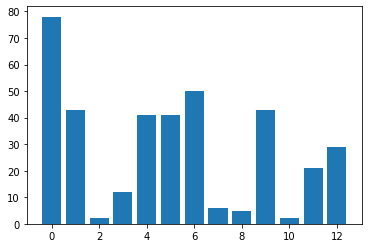

In [7]:
# label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### Plain Good Ol' XGBClassifier 

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=3456)

In [9]:
X_valid.head(2)

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID,PURCHASEDAT_MONTH,PURCHASEDAT_DAY,PURCHASEDAT_HOUR,PURCHASEDAT_MINUTE,PURCHASEDAT_DAYOFWEEK,PAID_AT
162,2021-08-06 11:28:03.723042+00:00,LIBERTY LIFE,66204,2021-07-29 12:23:00+00:00,False,25,Male,3,200000,ID_ECX9BS4A,ID_gc7nq4n3,7,29,12,23,3,afternoon
122,2022-03-10 18:25:42.112294+00:00,STATES BARBERSHOP,11400,2022-01-14 22:05:00+00:00,False,25,Female,6,1000000,ID_180RJKP4,ID_cadxowa4,1,14,22,5,4,evening


In [10]:
X_train.columns

Index(['MERCHANT_CATEGORIZED_AT', 'MERCHANT_NAME', 'PURCHASE_VALUE',
       'PURCHASED_AT', 'IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'USER_AGE',
       'USER_GENDER', 'USER_HOUSEHOLD', 'USER_INCOME', 'USER_ID',
       'Transaction_ID', 'PURCHASEDAT_MONTH', 'PURCHASEDAT_DAY',
       'PURCHASEDAT_HOUR', 'PURCHASEDAT_MINUTE', 'PURCHASEDAT_DAYOFWEEK',
       'PAID_AT'],
      dtype='object')

In [11]:
useful_features = [c for c in train.columns if c not in ('MERCHANT_CATEGORIZED_AS', 'MERCHANT_CATEGORIZED_AT', 'PURCHASED_AT', 'USER_ID', 'Transaction_ID')]
object_columns = [c for c in useful_features if train[c].dtype == 'object']
numerical_columns = ['USER_INCOME', 'PURCHASE_VALUE'] # we'll scale these

In [12]:
test['PAID_AT'].fillna('NA')

0        morning
1      afternoon
2        morning
3      afternoon
4      afternoon
         ...    
553    afternoon
554      morning
555    afternoon
556    afternoon
557      morning
Name: PAID_AT, Length: 558, dtype: object

In [13]:
x_train = X_train[useful_features].copy()
x_valid = X_valid[useful_features].copy()
x_test = test[useful_features].fillna('noon').copy()

In [14]:
# Ordinal Encode categorical values
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
x_train[object_columns] = ord_enc.fit_transform(x_train[object_columns])
x_valid[object_columns] = ord_enc.transform(x_valid[object_columns])
x_test[object_columns] = ord_enc.transform(x_test[object_columns])


# scaling numerical features
sc = StandardScaler()
x_train[numerical_columns] = sc.fit_transform(x_train[numerical_columns])
x_valid[numerical_columns] = sc.transform(x_valid[numerical_columns])
x_test[numerical_columns] = sc.transform(x_test[numerical_columns])

In [15]:
model = XGBClassifier()
model.fit(x_train, y_train)
dr = model.predict(x_valid)
preds = model.predict_proba(x_valid)
ll = metrics.accuracy_score(y_valid, dr)
print(ll)


0.47368421052631576


In [16]:
terd = model.predict_proba(x_test)

In [17]:
sample_submission[['Bills & Fees', 'Data & WiFi', 'Education',
       'Emergency fund', 'Family & Friends', 'Going out', 'Groceries',
       'Health', 'Loan Repayment', 'Miscellaneous', 'Rent / Mortgage',
       'Shopping', 'Transport & Fuel']]= terd

In [18]:
sample_submission.to_csv('../data/submissions/ss_xgboost.csv', index=False)

In [19]:
sample_submission

,Transaction_ID,Bills & Fees,Data & WiFi,Education,Emergency fund,Family & Friends,Going out,Groceries,Health,Loan Repayment,Miscellaneous,Rent / Mortgage,Shopping,Transport & Fuel
0,ID_00x9h2yx,0.293052,0.013028,0.246041,0.027152,0.344368,0.002760,0.001999,0.008701,0.005286,0.012737,0.032058,0.009432,0.003386
1,ID_01db594f,0.013250,0.000103,0.000191,0.000414,0.000169,0.981213,0.000865,0.000235,0.000172,0.001140,0.000647,0.000804,0.000797
2,ID_07pm99no,0.004882,0.002541,0.001638,0.001223,0.044077,0.721596,0.041705,0.136691,0.001401,0.012229,0.003521,0.003210,0.025286
3,ID_09jryhkd,0.260640,0.188306,0.005150,0.004039,0.020487,0.341233,0.015317,0.003907,0.024338,0.077881,0.025904,0.007812,0.024985
4,ID_0ccv924c,0.028224,0.013414,0.009113,0.005906,0.019379,0.037294,0.016042,0.004351,0.201153,0.022831,0.613474,0.016364,0.012456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,ID_zvole537,0.003286,0.016917,0.004808,0.009016,0.039620,0.103627,0.028232,0.013339,0.092136,0.008000,0.030018,0.448865,0.202136
554,ID_zy4igt1w,0.226509,0.001369,0.002351,0.000734,0.719065,0.006277,0.002163,0.017054,0.003607,0.003271,0.000881,0.001541,0.015178
555,ID_zy4urqmq,0.033265,0.036034,0.003966,0.010829,0.008215,0.555219,0.001798,0.002173,0.251079,0.037376,0.011150,0.002884,0.046012
556,ID_zym0pkxl,0.063148,0.000257,0.001486,0.021835,0.902607,0.002136,0.000452,0.001247,0.000616,0.002752,0.002659,0.000233,0.000572
